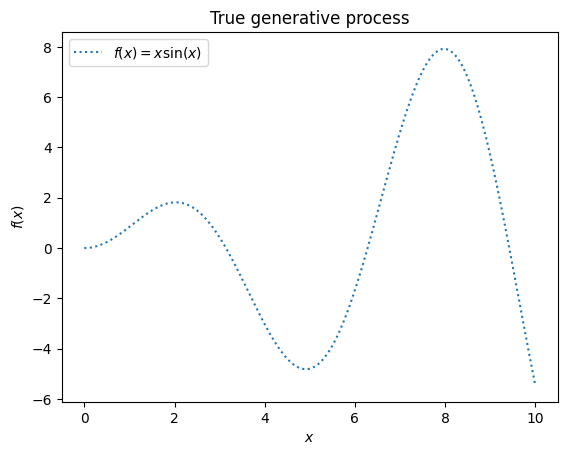

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

x = np.linspace(start = 0,stop = 10,num=1000).reshape(-1,1)
y = np.squeeze(x*np.sin(x))

plt.plot(x, y, label=r"$f(x) = x \sin(x)$", linestyle="dotted")
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
_ = plt.title("True generative process")

In [32]:
rng = np.random.RandomState()
training_indices = rng.choice(np.arange(y.size), size = 6, replace = False)
x_train, y_train = x[training_indices], y[training_indices]


kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
gaussian_process.fit(x_train, y_train)

GaussianProcessRegressor(kernel=1**2 * RBF(length_scale=1),
                         n_restarts_optimizer=9)

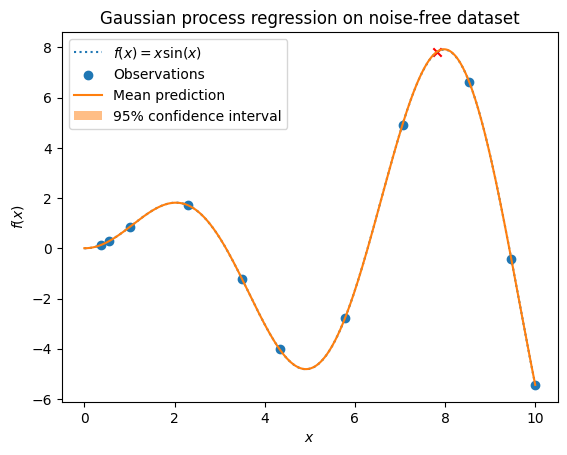

In [42]:
mean_prediction, std_prediction = gaussian_process.predict(x, return_std=True)
max_std_ind = np.argmax(std_prediction)
plt.plot(x, y, label=r"$f(x) = x \sin(x)$", linestyle="dotted")
plt.scatter(x_train, y_train, label="Observations")
plt.plot(x, mean_prediction, label="Mean prediction")
plt.fill_between(
    x.ravel(),
    mean_prediction - 1.96 * std_prediction,
    mean_prediction + 1.96 * std_prediction,
    alpha=0.5,
    label=r"95% confidence interval",
)
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
_ = plt.title("Gaussian process regression on noise-free dataset")
plt.scatter(x[max_std_ind],mean_prediction[max_std_ind],c='red',marker='x')

In [41]:
iter = 1
for i in range(iter):
    new_x = x[max_std_ind]
    new_y = y[max_std_ind]
    x_train_new = np.append(x_train, new_x).reshape(-1,1)
    y_train_new = np.append(y_train, new_y)
    gaussian_process.fit(x_train_new,y_train_new)
    mean_prediction, std_prediction = gaussian_process.predict(x, return_std=True)
    max_std_ind = np.argmax(std_prediction)
    x_train, y_train = x_train_new, y_train_new
    print(x_train)

[[ 3.5035035 ]
 [ 0.37037037]
 [ 0.54054054]
 [ 4.33433433]
 [ 7.05705706]
 [ 1.01101101]
 [10.        ]
 [ 8.53853854]
 [ 5.78578579]
 [ 9.46946947]
 [ 2.3023023 ]]


In [32]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.preprocessing import StandardScaler
import sklearn.gaussian_process.kernels as k
import matplotlib.pyplot as plt
from scipy.stats import qmc

def time_dependent_function(time, laser, ratios):
    laser_time = laser*np.ones(len(time)).reshape(-1,1)
    mat_time = (ratios[0] + ((ratios[1]-ratios[0])/time.max())*time).reshape(-1,1)
    T = (0.3*np.cos(20*np.pi*time/time.max()) + 150*np.log(laser_time[:,0]**2) - 30*(mat_time[:,0]**2)
         + 10*np.random.rand(len(time))).reshape(-1,1)
    A = (2*mat_time[:,0]*np.sin(np.pi*(time+mat_time[:,0])/(2*time.max())) - (T[:,0]/1000)**2 + 5).reshape(-1,1)
    h = (5 / (A**2)).reshape(-1,1) + 0.02*np.random.rand(len(time),1)
    w = (1/2 * A).reshape(-1,1) + 0.001*np.random.rand(len(time),1)
    x_sample = np.concatenate((time.reshape(-1,1), laser_time, mat_time, T, A),axis=1)
    y_sample = np.concatenate((h,w),axis=1)
    return x_sample, y_sample


scaler = StandardScaler()
samples = 10
sampler = qmc.LatinHypercube(d=3)
L_R_samples = sampler.random(n=samples)
L_R_samples = qmc.scale(L_R_samples,[400, 0, 0],[700, 1, 1])
time = np.arange(0,20)
x_train = np.zeros((len(time)*samples, 5))
y_train = np.zeros((len(time)*samples,2))
for i in range(samples):
    x_curr, y_curr = time_dependent_function(time,L_R_samples[i,0],L_R_samples[i,1:])
    x_train[(i*len(time)):(len(time)*(i+1)),:] = x_curr
    y_train[(i*len(time)):(len(time)*(i+1)),:] = y_curr
scaled_X_train = scaler.fit_transform(x_train)
kernel = k.Matern()+k.RBF()
gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=25)
gaussian_process.fit(scaled_X_train, y_train)

GaussianProcessRegressor(kernel=Matern(length_scale=1, nu=1.5) + RBF(length_scale=1),
                         n_restarts_optimizer=25)

In [34]:

def closest_data(time, x_samples, new_sample, x_train):
    distances = np.linalg.norm(x_samples-new_sample, axis=1)
    closest_index = np.argmin(distances)
    laser_time = new_sample[0]*np.ones(len(time)).reshape(-1,1)
    mat_time = (new_sample[1] + ((new_sample[2]-new_sample[1])/time.max())*time).reshape(-1,1)
    signal_train = x_train[(len(time)*closest_index):(len(time)*(closest_index+1)),3:]
    x_predict_new = np.concatenate((time.reshape(-1,1),laser_time,mat_time,signal_train),axis=1)
    return x_predict_new

def random_sampler_std(time, samples, bounds, x_old_samples, x_train, gp):
    l_bound = bounds[0]
    u_bound = bounds[1]
    sampler = qmc.LatinHypercube(d=len(l_bound))
    sample = sampler.random(n=samples)
    sample = qmc.scale(sample,l_bound,u_bound)
    total_predict = np.zeros((len(time)*samples, 5))
    for i in range(samples):
        x_train_i = closest_data(time, x_old_samples, sample[i,:], x_train)
        total_predict[(i*len(time)):((i+1)*len(time))] = x_train_i
    scaler = StandardScaler()
    scaler.fit_transform(x_train)
    total_predict = scaler.transform(total_predict)
    _, std_prediction = gp.predict(total_predict,return_std=True)
    std_samples = std_prediction[:,0].reshape(samples,len(time))
    std_max, std_mean = np.max(std_samples, axis = 1), np.mean(std_samples, axis = 1)
    return std_max, std_mean, sample

[4.77395366e+02 1.59827189e-01 4.30442832e-04]


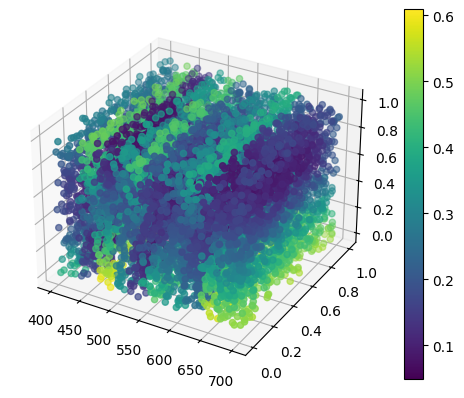

In [28]:
std_max, _, sample = random_sampler_std(time, 10000, [[400,0,0],[700,1,1]], L_R_samples, x_train, gaussian_process)
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
c = ax.scatter(sample[:,0], sample[:,1], sample[:,2], c=std_max)
fig.colorbar(c)
print(sample[np.argmax(std_max),:])

In [ ]:
iter = 100
x_train_iter = x_train
y_train_iter = y_train
x_sample_iter = L_R_samples
max_std_iter = np.zeros(iter+1)
max_std_iter[0] = np.max(random_sampler_std(time, 5000, [[400, 0, 0],[700, 1, 1]], x_sample_iter, x_train_iter, gaussian_process)[0])
for i in range(iter):
    std_max, _, sample = random_sampler_std(time, 5000, [[400, 0, 0],[700, 1, 1]], x_sample_iter, x_train_iter, gaussian_process)
    max_std_iter[i+1] = np.max(std_max)
    new_sample_i = sample[np.argmax(std_max),:].reshape(1,-1)
    x_sample_iter = np.concatenate((x_sample_iter, new_sample_i), axis = 0)
    new_train_x, new_train_y = time_dependent_function(time, new_sample_i[0,0], new_sample_i[0,1:])
    x_train_iter = np.concatenate((x_train_iter, new_train_x), axis = 0)
    y_train_iter = np.concatenate((y_train_iter, new_train_y), axis = 0)
    x_train_iter_scaled = StandardScaler().fit_transform(x_train_iter)
    gaussian_process.fit(x_train_iter_scaled, y_train_iter)

plt.plot(max_std_iter)

C:\Users\broke\AppData\Roaming\Python\Python311\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\broke\AppData\Roaming\Python\Python311\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\broke\AppData\Roaming\Python\Python311\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as 